Other tutorial : https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/convert_odt_model_to_TFLite.ipynb#scrollTo=ChfN-tzBXqko

# Clone tensorflow models repository 

In [ ]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 78360, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 78360 (delta 70), reused 130 (delta 54), pack-reused 78197
Receiving objects: 100% (78360/78360), 593.59 MiB | 23.99 MiB/s, done.
Resolving deltas: 100% (55693/55693), done.


In [ ]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

# Install the object detection API 

In [ ]:
!cd models/research && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 11.0 MB 12.4 MB/s 
     |████████████████████████████████| 352 kB 40.8 MB/s 
     |████████████████████████████████| 2.2 MB 30.9 MB/s 
     |████████████████████████████████| 25.0 MB 42.5 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 116 kB 59.3 MB/s 
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 1.3 MB 56.2 MB/s 
     

## Test the installation 

In [ ]:
!cd models/research && python object_detection/builders/model_builder_tf2_test.py 

2022-10-31 16:43:26.409688: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 16:43:27.936678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-31 16:43:27.936820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-31 16:43:27.936839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

# Import librairies 

In [ ]:
import os 
import pathlib
import tensorflow as tf 

import time
from object_detection.utils import label_map_util 
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# Enable GPU dynamic memory allocation 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus : 
    tf.confi.experimental.set_memory_growth(gpu, True)

# Download images : 

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

--2022-10-31 22:29:06--  https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195368 (191K) [image/jpeg]
Saving to: ‘walkingdog.jpeg’

walkingdog.jpeg     100%[===================>] 190.79K  --.-KB/s    in 0.09s   

2022-10-31 22:29:06 (2.08 MB/s) - ‘walkingdog.jpeg’ saved [195368/195368]

--2022-10-31 22:29:06--  https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160514 (157K) [image/jpeg]
Saving to: ‘traffic.jpeg’

traffic.jpeg        

In [ ]:
IMAGE_PATH = ["intersection.jpeg","traffic.jpeg","jungle.jpeg","walkingdog.jpeg"]

# Download and extract model files :

Get url from the "Object Detection Zoo"

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [ ]:
# URL of the model :
url ="http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_1024x1024_coco17_tpu-32.tar.gz"

PATH_TO_THE_MODEL_DIR = tf.keras.utils.get_file(
    fname="centernet_hg104_1024x1024_coco17_tpu-32",
    origin=url, 
    untar=True
)
PATH_TO_THE_MODEL_DIR

1424430731/1424430731 [==============================] - 12s 0us/step


'/root/.keras/datasets/centernet_hg104_1024x1024_coco17_tpu-32'

# Downloading labels files : 

In [ ]:
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(
    fname="mscoco_label_map.pbtxt",
    origin=url,
    untar=False
)
PATH_TO_LABELS

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [ ]:
#To see what is inside the file : 
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


# Load the model

In [ ]:
PATH_TO_SAVED_MODEL= PATH_TO_THE_MODEL_DIR +"/saved_model"

print("Loading model...", end="")
start_time=time.time()

#Loading the saved model and building the detection function : 
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time= time.time()

elapsed_time = end_time -start_time
print("Done, elapsed time : {} seconds".format(elapsed_time))


Loading model...

Done, elapsed time : 48.16936182975769 seconds


# Loading the labels :

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap (
    PATH_TO_LABELS,
    use_display_name=True
)

In [ ]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

# Helper function 

In [ ]:
## Helper function 

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

# Do some object detection 

In [ ]:
def detect_objects (image_path) : 
    print("Running inference for {}...".format(image_path), end="")
    image_np= load_image_into_numpy_array(image_path)

    #The input needs to be a tensor, convert it using 'tf.convert_to_tensor'. 
    input_tensor= tf.convert_to_tensor(image_np)

    input_tensor= input_tensor[tf.newaxis,...]
    
    #Do the detection 
    detections = detect_fn(input_tensor)

    #All outputs are batches tensors 
    #Convert numpy arrays, and take index[0] to remove the batch dimension 
    #We are only interested in the first num_detections
    num_detections = int(detections.pop("num_detections"))
    detections={key: value[0,:num_detections].numpy() for key, value in detections.items()}
    detections["num_detections"]= num_detections

    #Detection classes should be ints : 
    detections["detection_classes"] = detections["detection_classes"].astype(np.int)

    #show classes :
    unique_classes = set(detections["detection_classes"])
    print("classes found : ")

    for classes in unique_classes : 
        print(category_index[classes]["name"])


    image_np_with_detections= image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections, 
        detections["detection_boxes"],
        detections["detection_classes"],
        detections["detection_scores"],
        category_index, 
        use_normalized_coordinates =True, 
        max_boxes_to_draw=200,
        min_score_thresh=0.30, 
        agnostic_mode=False
    )

    plt.figure(figsize=(15,10))
    plt.imshow(image_np_with_detections)
    print("Done")
    plt.show()

In [ ]:
IMAGE_PATH

['intersection.jpeg', 'traffic.jpeg', 'jungle.jpeg', 'walkingdog.jpeg']

Running inference for intersection.jpeg...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


classes found : 
potted plant
person
bicycle
car
bus
truck
traffic light
fire hydrant
bottle
stop sign
parking meter
bench
clock
orange
handbag
Done


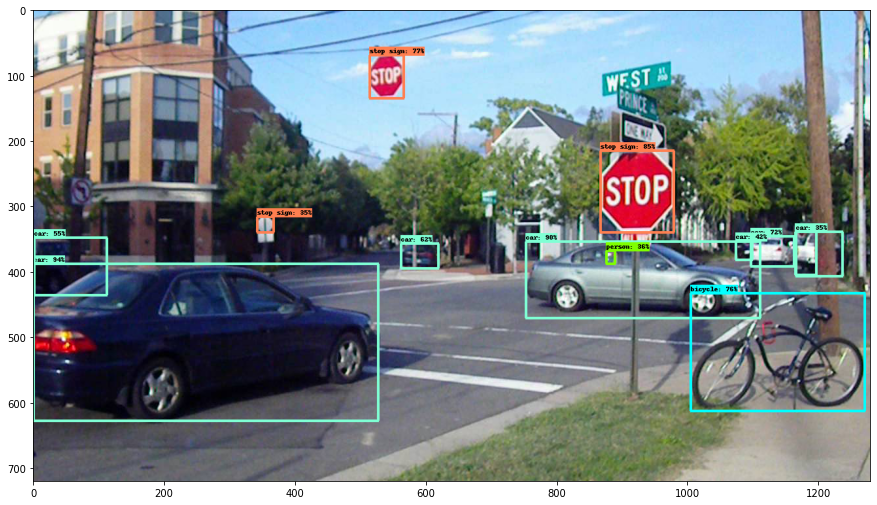

In [ ]:
detect_objects(IMAGE_PATH[0])

Running inference for traffic.jpeg...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


classes found : 
potted plant
person
bicycle
car
motorcycle
suitcase
bus
truck
traffic light
fire hydrant
stop sign
parking meter
cup
Done


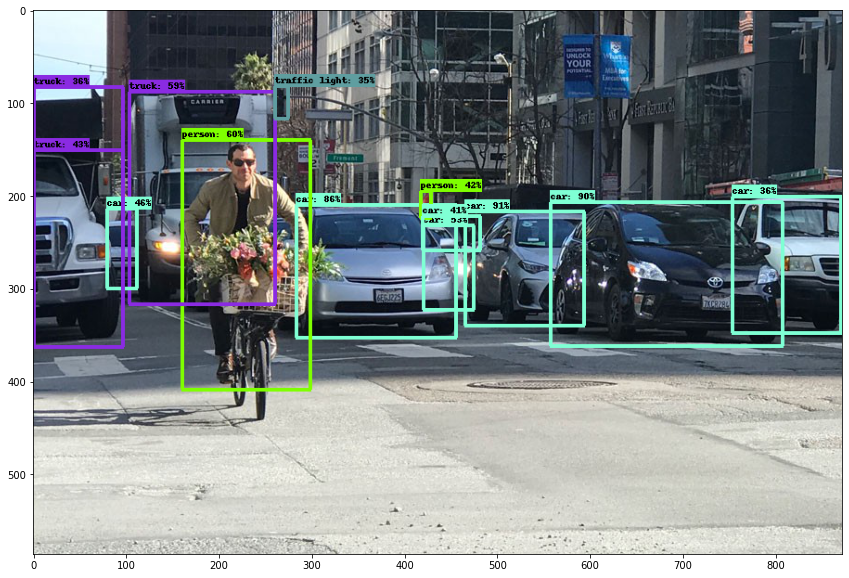

In [ ]:
detect_objects(IMAGE_PATH[1])

Running inference for jungle.jpeg...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


classes found : 
person
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
umbrella
sports ball
apple
sandwich
orange
broccoli
carrot
donut
cake
potted plant
teddy bear
Done


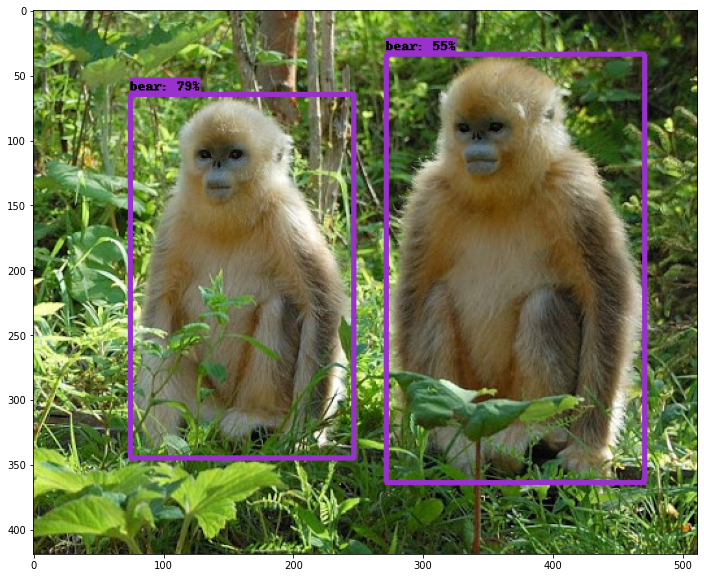

In [ ]:
detect_objects(IMAGE_PATH[2])

Running inference for walkingdog.jpeg...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


classes found : 
person
car
bench
bird
dog
backpack
umbrella
handbag
tie
frisbee
sports ball
kite
baseball glove
skateboard
surfboard
tennis racket
bottle
cup
bowl
remote
cell phone
book
clock
scissors
hair drier
Done


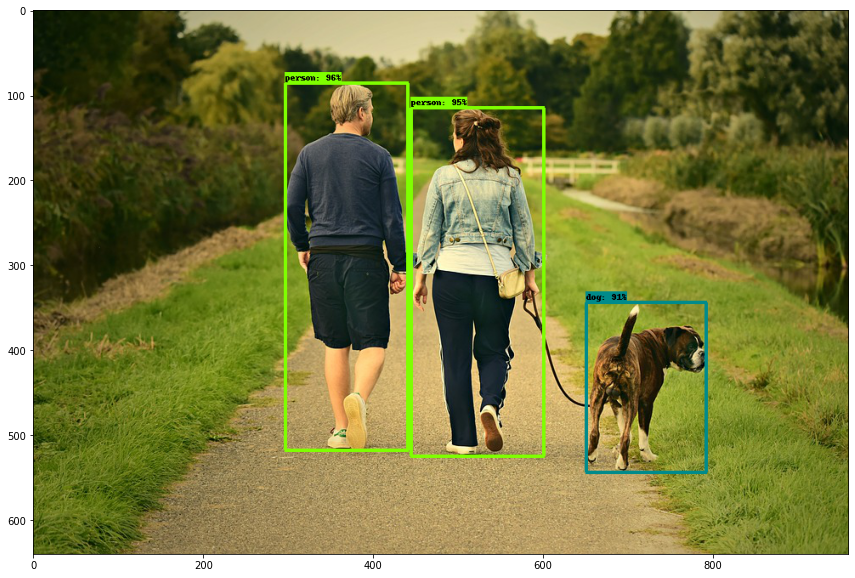

In [ ]:
detect_objects(IMAGE_PATH[3])